In [1]:
import torch
import math
from ksddescent import ksdd_lbfgs, ksdd_gradient
from ksddescent.contenders import svgd, mmd_lbfgs
import matplotlib.pyplot as plt
import numpy as np

from ksd_descent_gaussian import ksdd_lbfgs_gaussian


In [2]:
# define the score function

def score(x):
    return -x / 0.3

def potential(x):
    return (x ** 2).sum(dim=1)


# seems to be the target
def sampler(n_points):
    return math.sqrt(0.3) * torch.randn(n_points, 2)


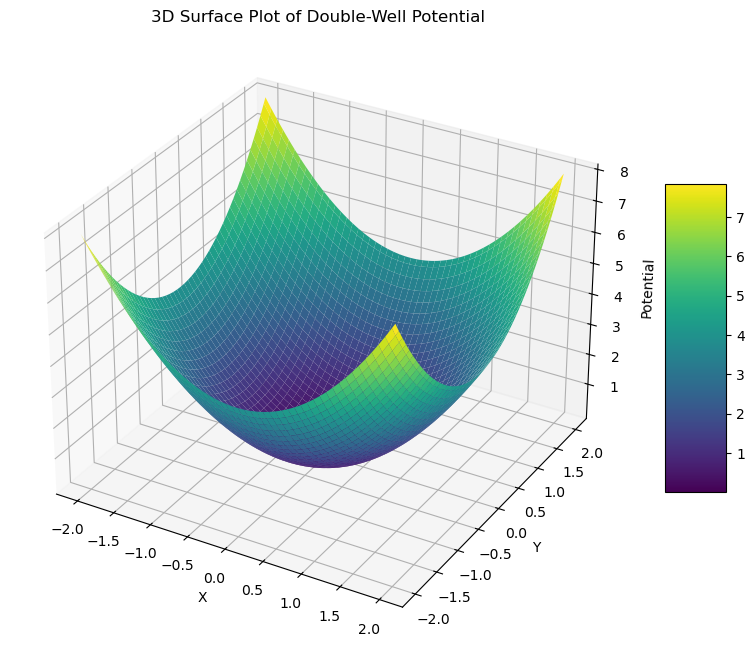

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create a grid of points
x = np.linspace(-2, 2, 100)
y = np.linspace(-2, 2, 100)
X, Y = np.meshgrid(x, y)

# Calculate the potential for each point
Z = np.zeros_like(X)
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        point = torch.tensor([[X[i,j], Y[i,j]]])
        Z[i,j] = potential(point).item()

# Create the 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
surface = ax.plot_surface(X, Y, Z, cmap='viridis')

# Customize the plot
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Potential')
ax.set_title('3D Surface Plot of Double-Well Potential')

# Add a color bar
fig.colorbar(surface, ax=ax, shrink=0.5, aspect=5)

plt.show()


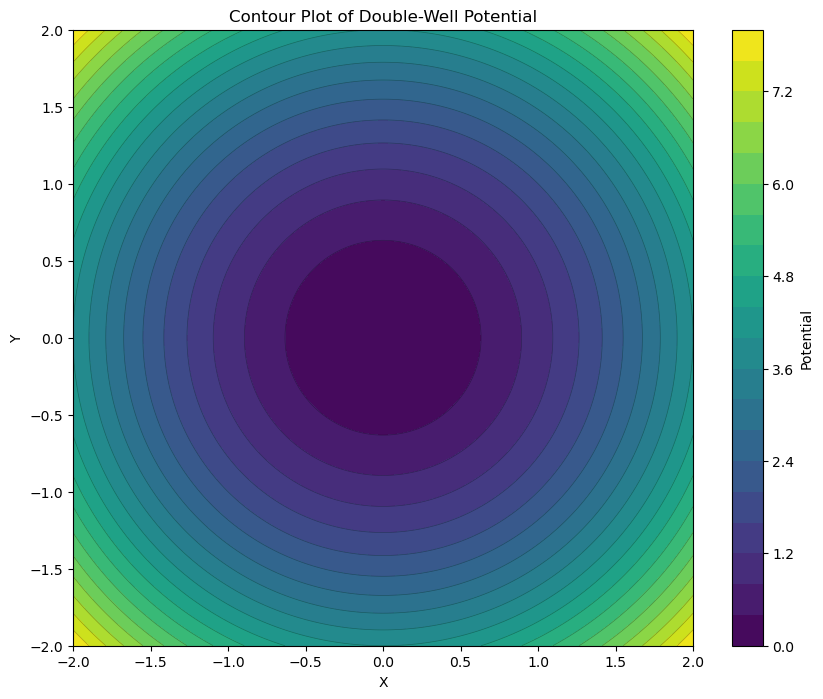

In [4]:
# Create a contour plot for the double-well potential

# Create a grid of points
x = np.linspace(-2, 2, 200)
y = np.linspace(-2, 2, 200)
X, Y = np.meshgrid(x, y)

# Calculate the potential for each point
Z = np.zeros_like(X)
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        point = torch.tensor([[X[i,j], Y[i,j]]])
        Z[i,j] = potential(point).item()

# Create the contour plot
plt.figure(figsize=(10, 8))
contour = plt.contourf(X, Y, Z, levels=20, cmap='viridis')
plt.colorbar(contour, label='Potential')

# Customize the plot
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Contour Plot of Double-Well Potential')

# Add contour lines
plt.contour(X, Y, Z, levels=20, colors='k', alpha=0.3, linewidths=0.5)

plt.show()


In [5]:

n_samples = 500 # affects how many samples in the reparameterization trick
p = 2 # dimension

# Define initial parameters for the Gaussian distribution
m0 = torch.tensor([3.5, 4.0])  # mean
L0 = torch.tensor([[1.5, 0.0], [0.4, 0.4]])  # lower triangular matrix for covariance

bw = 0.01 # bandwidth of the kernel

# call the Gaussian KSD descent
m_ksd, L_ksd, m_traj, L_traj, _ = ksdd_lbfgs_gaussian(m0.clone(), L0.clone(), n_samples, score, bw=bw, store=True)



# Plots

# Now, let's plot the trajectories

In [6]:
# Check the length of m_traj and L_traj
print("Length of m_traj:", len(m_traj))
print("Length of L_traj:", len(L_traj))


Length of m_traj: 13
Length of L_traj: 13


In [7]:
# Print the content of m_traj
for i, m in enumerate(m_traj):
    print(f"Iteration {i}: m = {m}")


Iteration 0: m = tensor([3.3902, 3.8695])
Iteration 1: m = tensor([3.3337, 3.8064])
Iteration 2: m = tensor([3.0325, 3.3840])
Iteration 3: m = tensor([2.2430, 2.4094])
Iteration 4: m = tensor([1.0643, 1.0175])
Iteration 5: m = tensor([-0.2476, -0.1683])
Iteration 6: m = tensor([-0.3738, -0.2782])
Iteration 7: m = tensor([0.0052, 0.0892])
Iteration 8: m = tensor([0.0052, 0.0892])
Iteration 9: m = tensor([0.1099, 0.1658])
Iteration 10: m = tensor([0.1176, 0.1359])
Iteration 11: m = tensor([0.1176, 0.1359])
Iteration 12: m = tensor([0.1176, 0.1359])


/var/folders/f6/8vzd7z213t58mr4nsz9bys0w0000gn/T/ipykernel_32404/22740767.py:21: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(X, Y, Z, levels=[np.exp(-0.5)], colors="red", linestyles="dashed", label=f"1 Std Dev Contour (Iteration {i})")
/var/folders/f6/8vzd7z213t58mr4nsz9bys0w0000gn/T/ipykernel_32404/22740767.py:31: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(X, Y, final_Z, levels=[np.exp(-0.5)], colors="black", linewidths=2, label="Final 1 Std Dev Contour")


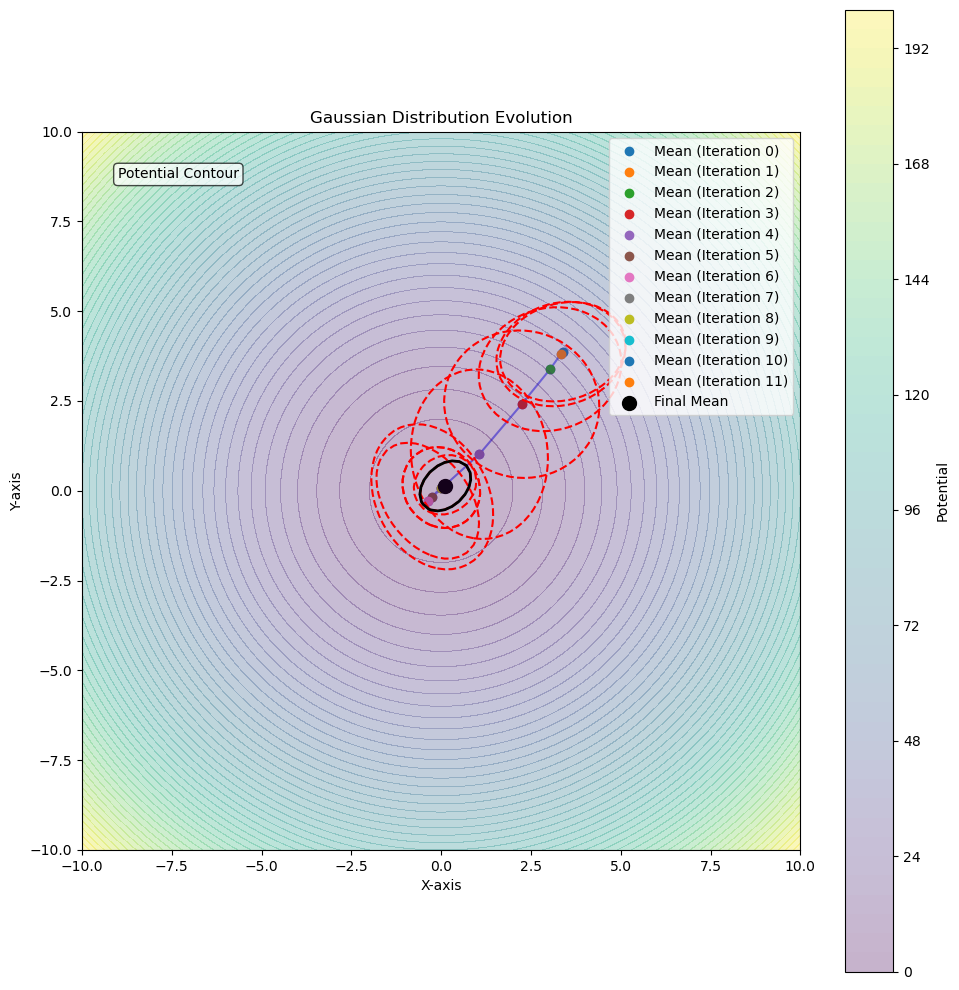

In [8]:
# Plot the evolution of the Gaussian distributions using the mean and Cholesky factor of covariance stored in the lists m_traj, L_traj

plt.figure(figsize=(10, 10))  # Make the plot figure size square

# Extract the means from m_traj for plotting the trajectory
means = np.array([m.detach().numpy() for m in m_traj])

# Create a grid of points for plotting the Gaussian density
X, Y = np.meshgrid(np.linspace(-10, 10, 100), np.linspace(-10, 10, 100))
XX = torch.tensor(np.c_[X.ravel(), Y.ravel()], dtype=torch.float32)

for i, (m, L) in enumerate(zip(m_traj[:-1], L_traj[:-1])):  # Exclude the last iteration
    # Compute the Gaussian density for the current mean and covariance
    cov = torch.matmul(L, L.T)
    inv_cov = torch.inverse(cov)
    diff = XX - m
    exponent = -0.5 * torch.sum(diff @ inv_cov * diff, dim=1)
    Z = torch.exp(exponent).reshape(X.shape).detach().numpy()
    
    # Plot only one contour line
    plt.contour(X, Y, Z, levels=[np.exp(-0.5)], colors="red", linestyles="dashed", label=f"1 Std Dev Contour (Iteration {i})")
    plt.scatter(m[0], m[1], label=f"Mean (Iteration {i})")

# Plot the final contour using a solid black curve
final_m, final_L = m_traj[-1], L_traj[-1]
final_cov = torch.matmul(final_L, final_L.T)
final_inv_cov = torch.inverse(final_cov)
final_diff = XX - final_m
final_exponent = -0.5 * torch.sum(final_diff @ final_inv_cov * final_diff, dim=1)
final_Z = torch.exp(final_exponent).reshape(X.shape).detach().numpy()
plt.contour(X, Y, final_Z, levels=[np.exp(-0.5)], colors="black", linewidths=2, label="Final 1 Std Dev Contour")
plt.scatter(final_m[0], final_m[1], color="black", s=100, label="Final Mean")

# Plot the trajectory line connecting the means
plt.plot(means[:, 0], means[:, 1], color="blue", linestyle="-", marker="o", alpha=0.5, zorder=0)

# Plot the contour of the potential function
potential_values = torch.zeros_like(XX[:, 0])
for i in range(len(XX)):
    potential_values[i] = potential(XX[i].unsqueeze(0))
potential_grid = potential_values.reshape(X.shape).detach().numpy()

# Plot the contour of the potential using regular scale
contour = plt.contourf(X, Y, potential_grid, levels=50, cmap='viridis', alpha=0.3)
cbar = plt.colorbar(contour, label='Potential')

# Add a label for the potential contour
plt.text(0.05, 0.95, 'Potential Contour', transform=plt.gca().transAxes, 
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

plt.title("Gaussian Distribution Evolution")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.xlim(-10, 10)
plt.ylim(-10, 10)
plt.gca().set_aspect('equal', adjustable='box')  # Ensure 1:1 aspect ratio
plt.legend()
plt.tight_layout()  # Adjust the layout to prevent clipping
plt.show()


TODO: use the potential function, plot the target Gaussian density

/var/folders/f6/8vzd7z213t58mr4nsz9bys0w0000gn/T/ipykernel_32404/2904171009.py:12: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(X, Y, Z_target, levels=[np.exp(-0.5)], colors="black", linewidths=2, label="1 Std Dev Contour (True Distribution)")


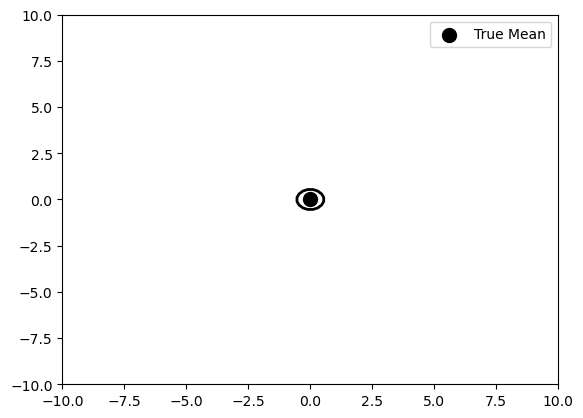

In [9]:
# Get the target Gaussian distribution information from the sampler function
target_mean = torch.zeros(2)
target_cov = 0.3 * torch.eye(2)
target_inv_cov = torch.inverse(target_cov)

# Compute the Gaussian density for the target distribution
diff = XX - target_mean
exponent = -0.5 * torch.sum(diff @ target_inv_cov * diff, dim=1)
Z_target = torch.exp(exponent).reshape(X.shape).detach().numpy()

# Plot the target distribution with a solid black contour
plt.contour(X, Y, Z_target, levels=[np.exp(-0.5)], colors="black", linewidths=2, label="1 Std Dev Contour (True Distribution)")

# Add a scatter point for the target mean
plt.scatter(target_mean[0], target_mean[1], color="black", s=100, label="True Mean")

plt.legend()
plt.show()


Final mean: tensor([0.1176, 0.1359])
Target mean: tensor([0., 0.])
Mean difference (L2 norm): 0.1797

Target covariance:
tensor([[0.3000, 0.0000],
        [0.0000, 0.3000]])

Final KSD covariance:
tensor([[0.5038, 0.1660],
        [0.1660, 0.4877]])


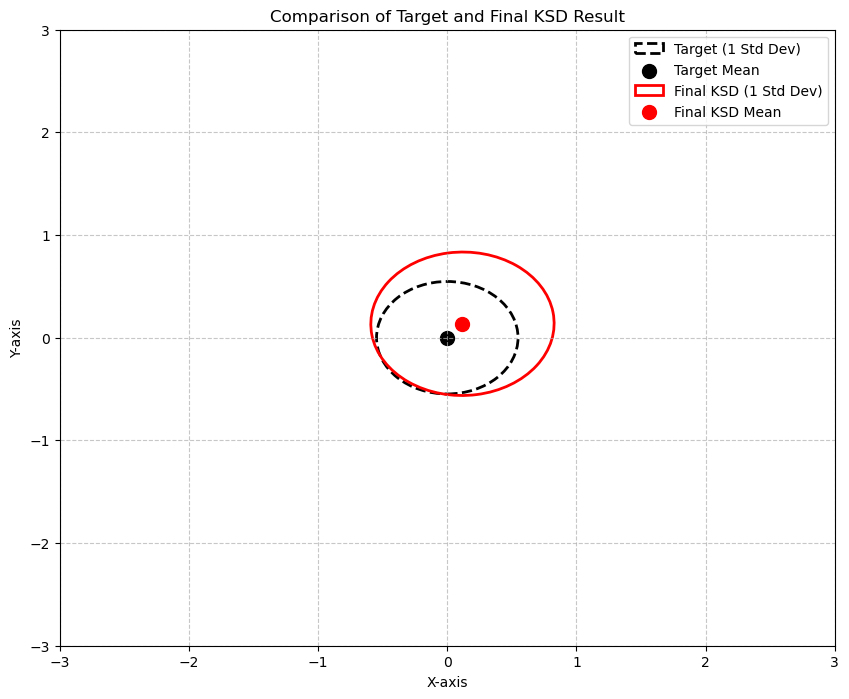

In [10]:
# Compare final KSD results with true target

# Import the Ellipse class from matplotlib.patches
from matplotlib.patches import Ellipse

# Extract the final mean and covariance from the KSD results
final_mean = m_ksd
final_cov = L_ksd @ L_ksd.T  # Reconstruct covariance from Cholesky factor

# Ensure both final_mean and target_mean are PyTorch tensors
final_mean = torch.tensor(final_mean) if isinstance(final_mean, np.ndarray) else final_mean
target_mean = torch.tensor(target_mean) if isinstance(target_mean, np.ndarray) else target_mean

# Calculate the difference between final and target mean
mean_diff = final_mean - target_mean
mean_diff_norm = torch.norm(mean_diff).item()

print(f"Final mean: {final_mean}")
print(f"Target mean: {target_mean}")
print(f"Mean difference (L2 norm): {mean_diff_norm:.4f}")
print(f"\nTarget covariance:\n{target_cov}")
print(f"\nFinal KSD covariance:\n{final_cov}")

# Plot comparison
plt.figure(figsize=(10, 8))

# Plot the target distribution
target_ellipse = Ellipse(xy=target_mean, width=2*np.sqrt(target_cov[0,0]), height=2*np.sqrt(target_cov[1,1]), 
                         angle=np.degrees(np.arctan2(target_cov[1,0], target_cov[0,0])/2),
                         facecolor='none', edgecolor='black', linestyle='--', linewidth=2, label='Target (1 Std Dev)')
plt.gca().add_artist(target_ellipse)
plt.scatter(target_mean[0].item(), target_mean[1].item(), color="black", s=100, label="Target Mean")

# Plot the final KSD result
final_ellipse = Ellipse(xy=final_mean, width=2*np.sqrt(final_cov[0,0]), height=2*np.sqrt(final_cov[1,1]), 
                        angle=np.degrees(np.arctan2(final_cov[1,0], final_cov[0,0])/2),
                        facecolor='none', edgecolor='red', linestyle='-', linewidth=2, label='Final KSD (1 Std Dev)')
plt.gca().add_artist(final_ellipse)
plt.scatter(final_mean[0].item(), final_mean[1].item(), color="red", s=100, label="Final KSD Mean")

plt.title("Comparison of Target and Final KSD Result")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.xlim(-3, 3)
plt.ylim(-3, 3)
plt.show()


# plot the performance metric
we use the reverse KL, ie
$$
\mathcal{D}_{KL}( \pi | \hat \mu_t ) = \int \pi(x) \log \frac{\pi(x)}{\hat \mu_t(x)} dx
$$
where $\pi$ is the target distribution, and $\hat \mu_t$ is the distribution following our inference trajectory at time $t$.

## Non-Gaussian target
- [ ] In this case, is it possible to use the potential to evaluate the performance metric?

# NN potential; difficult to optimize!!


```python
# Define a potential with a neural network

from mpl_toolkits.mplot3d import Axes3D
import torch.nn as nn
import torch.optim as optim

class PotentialNetwork(nn.Module):
    def __init__(self):
        super(PotentialNetwork, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.net(x).squeeze()

potential_net = PotentialNetwork()

# Train the neural network
def train_potential_net(epochs=1000, lr=0.001):
    optimizer = optim.Adam(potential_net.parameters(), lr=lr)
    for epoch in range(epochs):
        optimizer.zero_grad()
        x = torch.randn(1000, 2) * 3
        y = potential_net(x)
        # Loss to create a more complex landscape
        loss = -torch.mean(torch.sin(5 * x[:, 0]) * torch.sin(5 * x[:, 1]) * y)
        loss += 0.1 * torch.mean(y**2)  # Regularization to prevent extreme values
        loss.backward()
        optimizer.step()
        if (epoch + 1) % 100 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

train_potential_net()

def potential(x):
    return potential_net(x)

def score(x):
    x.requires_grad_(True)
    pot = potential(x)
    grad = torch.autograd.grad(pot.sum(), x, create_graph=True)[0]
    return -grad

# Define a sampler for this distribution
def sampler(n_points):
    # Use rejection sampling to generate samples
    samples = []
    while len(samples) < n_points:
        x = torch.randn(2) * 3  # Propose from a wider Gaussian
        u = torch.rand(1)
        if u < torch.exp(-potential(x.unsqueeze(0)).squeeze() + 0.5 * (x**2).sum()):
            samples.append(x)
    return torch.stack(samples)

# Create a 3D surface plot of the potential function
x = np.linspace(-3, 3, 100)
y = np.linspace(-3, 3, 100)
X, Y = np.meshgrid(x, y)
XY = torch.tensor(np.stack([X, Y], axis=-1), dtype=torch.float32)
Z = potential(XY).detach().numpy()

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, Z, cmap='viridis')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Potential')
ax.set_title('3D Surface Plot of Neural Network Potential')
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

# Test the functions
x_test = torch.tensor([[1.0, 1.0], [-1.0, -1.0], [0.0, 0.0], [2.0, 2.0], [-2.0, -2.0]], dtype=torch.float32)
print("Score at test points:")
print(score(x_test))
print("\nPotential at test points:")
print(potential(x_test))
print("\nSample 5 points:")
print(sampler(5))
```